<center>
   
## [Acoustic Metamaterial Generative Design and Optimisation Pipeline](https://github.com/frantic0/ammgdop)

Author: [Francisco Bernardo](https://fbernardo.com). This material is subject to the terms and conditions of the [Creative Commons CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/) license. Free use is permitted for any non-commercial purpose.

This notebook implements basic data analysis and the required post-processing operations for extracting measurements from the acoustic pressure field obtained from the Helmholtz solver, including:

* Absolute pressure field
* Transmission Loss
* Acoustic Velocity
* Peak Acoustic Pressure

To set up the notebook with the required dependencies make sure you have them installed in the system, before you load the notebook. Use your package manager such as conda or pip to install then, for instance:

> $ pip3 install numpy

> $ pip3 install pandas

> $ pip3 install matplotlib


In [194]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import os

# pd.set_option("display.precision", 2)

To start analysing the labyrinthine bricks [dataset](https://bigml.com/user/francisco/gallery/dataset/5163ad540c0b5e5b22000383) let's read the data using `parseDatNames`

In [195]:
def parseDatNames(filename):
    res = [] # Initialize
    if filename[-6:] != ".names":
        filename = filename + ".names"
    with open(filename, 'r') as f:
        isHeader = True
        for line in f:
            if 'Variables in columns' in line:
                isHeader = False
                continue
            if isHeader == True:
                continue

            # strParse1: get rid of 1: boundary mean, and split over "over"
            strParse1 = line.strip().split(':')[-1].strip().split('over')
            if len(strParse1) == 1:
                res.append(strParse1[0])
            else:
                if len(strParse1[0]) > 0:
                    itemName = strParse1[0]
                else:
                    strParse1[0] = itemName
                res.append(strParse1[0].strip() + '.' + strParse1[1].strip())
    return res

Let's take a look at the column names exported by Elmer for Brick 15:

In [196]:
filename = './data/brick-15/SPLmean.dat'

# Boundary Conditions
inletBC = 1
outletBC = 3

rho0 = 1.205
c0 = 343
flowDir = np.array([1, 0, 0])

# Parse input names:
column_names = parseDatNames(filename)

print(*column_names, sep ='\n')

pressure wave 1.bc 1
pressure wave 1.bc 3
pressure wave 2.bc 1
pressure wave 2.bc 3
pressure wave 1 grad 1.bc 1
pressure wave 1 grad 1.bc 3
pressure wave 1 grad 2.bc 1
pressure wave 1 grad 2.bc 3
pressure wave 1 grad 3.bc 1
pressure wave 1 grad 3.bc 3
frequency


Let’s have a look at data dimensionality, feature names, and feature types.

In [197]:
with open(filename, 'r') as f:
    res = np.array([np.fromstring(line.strip(), dtype=float, sep=' ') for line in f])

print("Shape of the data: {} \n".format(res.shape))          
  

print(res)


Shape of the data: (3, 11) 

[[ 9.99996690e-01  1.76879102e-01 -3.58492989e-44 -5.10295667e-01
  -3.83938528e-01 -7.46498713e+01  6.47656558e-03  5.62639495e-01
   4.14708727e+03  9.68715905e+01  4.00000000e+04]
 [ 9.99996690e-01 -1.40323266e+00  1.98647431e-42 -1.05654505e+00
  -1.23002487e+00 -6.02109086e+02 -2.35536803e+00  2.54414021e-01
  -2.66993452e+03 -8.08441723e+02  4.05000000e+04]
 [ 9.99996690e-01  8.19907481e-02 -9.24674080e-46  1.43998552e-01
   8.27310984e-02  4.45522274e+02 -3.86833498e+00  4.14476253e+00
  -5.99931059e+03  8.31491620e+02  4.10000000e+04]]


<details>
<summary>About printing DataFrames in Jupyter notebooks</summary>
<p>
In Jupyter notebooks, Pandas DataFrames are printed as these pretty tables seen above while `print(df.head())` is less nicely formatted.
By default, Pandas displays 20 columns and 60 rows, so, if your DataFrame is bigger, use the `set_option` function as shown in the example below:

```python
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)
```
</p>
</details>

Recall that each row corresponds to one frequency, an **instance**, and columns are **features** of this instance.

Let's now get the frequency and pressure values and assign to variables

In [225]:
freqVec = res[:, column_names.index('frequency')]
omegaVec = 2 * np.pi * freqVec

## Get pressure at inlet and outlet

pIn = res[:, column_names.index('pressure wave 1.bc ' + str(inletBC))] \
     + 1j * res[:, column_names.index('pressure wave 2.bc ' + str(inletBC))]

pOut = res[:, column_names.index('pressure wave 1.bc ' + str(outletBC))] \
     + 1j * res[:, column_names.index('pressure wave 2.bc ' + str(outletBC))]

print(pIn)
print(pOut)

[0.99999669-3.58492989e-44j 0.99999669+1.98647431e-42j
 0.99999669-9.24674080e-46j]
[ 0.1768791 -0.51029567j -1.40323266-1.05654505j  0.08199075+0.14399855j]



To calculate velocity at inlet, we use **uIn = 1j / rho0 / omegaVec * dp/dn**

To decompose the p to p+ and p-, we consider 

**p+ + p- = p** and **p+ - p- = uIn * rho0 * c0**

so, 

**p+ = (p + uIn * rho0 * c0) / 2**


In [224]:
#  Check if it is 3D
dim = 3
if "pressure wave 1 grad 3.bc 1" not in column_names:
    dim = 2
    flowDir = flowDir[:-1]

pGradIn, pGradOut = np.zeros((freqVec.size, dim), dtype=np.complex_), np.zeros((freqVec.size, dim), dtype=np.complex_)

# Get pGradIn and pGradOut
fmt = 'pressure wave {0:d} grad {1:d}.bc {2:s}'
for ind in range(dim):
    # Inlet
    strReal = fmt.format(1, ind+1, str(inletBC))
    strImag = fmt.format(2, ind+1, str(inletBC))
    pGradIn[:, ind] = res[:, column_names.index(strReal)] + 1j * res[:, column_names.index(strImag)]
    # outlet
    strReal = fmt.format(1, ind+1, str(outletBC))
    strImag = fmt.format(2, ind+1, str(outletBC))
    pGradOut[:, ind] = res[:, column_names.index(strReal)] + 1j * res[:, column_names.index(strImag)]
    
# Decomposition at inlet
dpdnIn = pGradIn.dot(flowDir)
uIn = 1j/rho0/omegaVec*dpdnIn
pInPlus = (pIn + uIn*rho0*c0)/2
pInMinus = pIn - pInPlus

# Decomposition at outlet
dpdnOut = pGradOut.dot(flowDir)
uOut = 1j/rho0/omegaVec*dpdnOut

# Transmission Loss
TL = 20*np.log10(np.abs(pInPlus)/np.abs(pOut))

# Plot
plt.close("all")
fig, ax = plt.subplots()
ax.minorticks_on()
ax.grid(which='both')
ln = plt.plot(freqVec, TL, '-o', label='Simulation')
plt.xlabel('Frequency, Hz')
plt.ylabel('Transmission Loss, dB')
plt.title(filename)
plt.show()



ValueError: 'pressure wave 2 grad 1.bc 1' is not in list

NameError: name 'pInPlus' is not defined

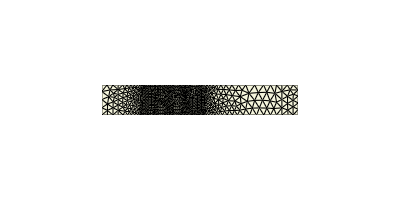

In [208]:
import vtk
from IPython.display import Image

def vtk_show(renderer, w=100, h=100):
    """
    Takes vtkRenderer instance and returns an IPython Image with the rendering.
    """
    renderWindow = vtk.vtkRenderWindow()
    renderWindow.SetOffScreenRendering(1)
    renderWindow.SetLineSmoothing(1)
    renderWindow.AddRenderer(renderer)
    renderWindow.SetSize(w, h)
    renderWindow.Render()
     
    windowToImageFilter = vtk.vtkWindowToImageFilter()
    windowToImageFilter.SetInput(renderWindow)
    windowToImageFilter.Update()
     
    writer = vtk.vtkPNGWriter()
    writer.SetWriteToMemory(1)
    writer.SetInputConnection(windowToImageFilter.GetOutputPort())
    writer.Write()
    data = memoryview(writer.GetResult()).tobytes()
    # data = str(buffer(writer.GetResult()))
    
    return Image(data)


vtu_filename = './data/vtus/grad/brick-40000_t0001.vtu'

colors = vtk.vtkNamedColors()
reader = vtk.vtkXMLUnstructuredGridReader()
reader.SetFileName(vtu_filename)
reader.Update()  # Needed because of GetScalarRange

# Get UnstructuredGrid and extract point data fields
unstructuredGrid = reader.GetOutput() 
pressure_wave_1 = unstructuredGrid.GetPointData().GetArray("pressure wave 1")
pressure_wave_2 = unstructuredGrid.GetPointData().GetArray("pressure wave 2")
spl = unstructuredGrid.GetPointData().GetArray("spl")
phase = unstructuredGrid.GetPointData().GetArray("phase")
pressure_wave_2_flux = unstructuredGrid.GetPointData().GetArray("pressure wave 2 flux")
pressure_wave_1_flux = unstructuredGrid.GetPointData().GetArray("pressure wave 1 flux")

# print(unstructuredGrid.keys())


# Create the mapper that corresponds the objects of the vtk.vtk file
# into graphics elements
mapper = vtk.vtkDataSetMapper()
mapper.SetInputData(unstructuredGrid)

# mapper.SetScalarRange(scalar_range)
mapper.ScalarVisibilityOff()

# Create the Actor
actor = vtk.vtkActor()
actor.SetMapper(mapper)
# actor.SetPosition(0, -200, -200)
# actor.SetScale(-20, -40, -20)
# actor.SetOrigin(0, -200, -200)
actor.GetProperty().EdgeVisibilityOn()
actor.GetProperty().EdgeVisibilityOn()
actor.GetProperty().SetLineWidth(0.5)
actor.GetProperty().SetColor(colors.GetColor3d("Beige"))
backface = vtk.vtkProperty()
backface.SetColor(colors.GetColor3d('Tomato'))
actor.SetBackfaceProperty(backface)

# Create the Renderer
renderer = vtk.vtkRenderer()
renderer.AddActor(actor)
actor.RotateY(90)
renderer.SetBackground(colors.GetColor3d('White'))

vtk_show(renderer, 400, 200)

# Create the RendererWindow
# renderer_window = vtk.vtkRenderWindow()
# renderer_window.SetSize(640, 480)
# renderer_window.AddRenderer(renderer)
# renderer_window.SetWindowName('ReadUnstructuredGrid')

# Create the RendererWindowInteractor and display the vtk_file
# interactor = vtk.vtkRenderWindowInteractor()
# interactor.SetRenderWindow(renderer_window)
# interactor.Initialize()
# interactor.Start()



### Complex Pressure components (real and imaginary)

In [229]:
print("** Pressure wave 1 (real)")

# print(pressure_wave_1)
print(type(pressure_wave_1))
# print("#values: {}".format(pressure_wave_1.GetNumberOfValues()))
print("#values: {}".format(pressure_wave_1.GetSize()))
print("Value Range: {}".format(pressure_wave_1.GetValueRange()))
print("Value at index {}: {}".format(0, pressure_wave_1.GetValue(0)))
print("Index of value {}: {}".format(pressure_wave_1.GetValueRange()[0], pressure_wave_1.LookupValue(pressure_wave_1.GetValueRange()[0])))
print("Index of value {}: {}".format(pressure_wave_1.GetValueRange()[1], pressure_wave_1.LookupValue(pressure_wave_1.GetValueRange()[1])))
# print(pressure_wave_1.len)


print("\n** Pressure wave 2 (imag) {}".format(type(pressure_wave_2)) )
# print(pressure_wave_2)
# print(repr(pressure_wave_2))
print("#values: {}".format(pressure_wave_2.GetSize()))
print("Value Range: {}".format(pressure_wave_2.GetValueRange()))
# print("Value at index {}: {}".format(0, pressure_wave_2.GetValue(0)))
print("Index of value {}: {}".format(pressure_wave_2.GetValueRange()[0], pressure_wave_2.LookupValue(pressure_wave_2.GetValueRange()[0])))
print("Index of value {}: {}".format(pressure_wave_2.GetValueRange()[1], pressure_wave_2.LookupValue(pressure_wave_2.GetValueRange()[1])))

# print(pressure_wave_1.len)


** Pressure wave 1 (real)
<class 'vtkmodules.vtkCommonCore.vtkDoubleArray'>
#values: 50873
Value Range: (-18.58334385824215, 15.094013639761364)
Value at index 0: -0.2690436474684704
Index of value -18.58334385824215: 7452
Index of value 15.094013639761364: 1842

** Pressure wave 2 (imag) <class 'vtkmodules.vtkCommonCore.vtkDoubleArray'>
#values: 50873
Value Range: (-3.366151627268815, 3.414775965669333)
Index of value -3.366151627268815: 9965
Index of value 3.414775965669333: 8267


### Absolute Pressure 

Here we calculate the absolute complex pressure from the real and imaginary components of the complex pressure. 

We iterate the Pressure Wave 1 and 2 arrays (vtkDoubleArrays, non-iterable) and zip up the resulting arrays in one array where absolute pressure is calculated for each index.



In [226]:

# from vtk import numpy_support

def absolute_pressure(real, imag): 
    return 20*math.log10(((math.sqrt(real**2+imag**2))/math.sqrt(2)))
    return 20*math.log(((math.sqrt(real**2+imag**2))/math.sqrt(2)))

pressure_wave_1_array = [ pressure_wave_1.GetValue(i) for i in range(0, pressure_wave_1.GetSize() ) ]
pressure_wave_2_array = [ pressure_wave_2.GetValue(i) for i in range(0, pressure_wave_2.GetSize() ) ] 

absolute_pressure_wave = np.array([ absolute_pressure(real, imag) for real, imag in zip(pressure_wave_1_array, pressure_wave_2_array) ])

print("** Absolute Pressure Wave {}".format( type(absolute_pressure_wave) ) )
# print(type(absolute_pressure_wave))
# print(absolute_pressure_wave)
print("#values: {}".format( len(absolute_pressure_wave) ))

min_absolute_pressure_wave = sorted(absolute_pressure_wave)[0]
max_absolute_pressure_wave = sorted(absolute_pressure_wave)[len(absolute_pressure_wave)-1]
print("Value Range: {} {}".format( min_absolute_pressure_wave , max_absolute_pressure_wave ))
print("Index of value {}: {}".format( min_absolute_pressure_wave, np.where(absolute_pressure_wave == min_absolute_pressure_wave)[0] ))
print("Index of value {}: {}".format( max_absolute_pressure_wave,  np.where(absolute_pressure_wave == max_absolute_pressure_wave)[0] ))

** Absolute Pressure Wave <class 'numpy.ndarray'>
#values: 50873
Value Range: -48.513294528803044 22.40256949234098
Index of value -48.513294528803044: [50382]
Index of value 22.40256949234098: [7452]


### Sound Pressure level

Here we calculated the sound pressure level (SPL) with 20 micropascal, a pressure reference related to human hearing




In [219]:
print("** Sound Pressure Level {}".format( type(spl) ) )
# print(spl)

spl_array = [ spl.GetValue(i) for i in range(0, spl.GetSize() ) ]
# print(spl_array)

print("#values: {}".format( len(spl_array) ))
print("Value Range: {}".format(spl.GetValueRange()))
print("Value at index {}: {}".format(0, spl.GetValue(0)))
print("Index of value {}: {}".format(spl.GetValueRange()[0], spl.LookupValue(spl.GetValueRange()[0])))
print("Index of value {}: {}".format(spl.GetValueRange()[1], spl.LookupValue(spl.GetValueRange()[1])))


** Sound Pressure Level <class 'vtkmodules.vtkCommonCore.vtkDoubleArray'>
#values: 50873
Value Range: (-48.5132945288, 22.4025694923)
Value at index 0: 0.0
Index of value -48.5132945288: 50382
Index of value 22.4025694923: 7452


### Phase

In [223]:
# print("phase")

print("** Phase {}".format( type(phase) ) )
# print(phase)

phase_array = [ phase.GetValue(i) for i in range(0, phase.GetSize() ) ]
# print(phase_array)

print("#values: {}".format( len(phase_array) ))
print("Value Range: {}".format( phase.GetValueRange()) )
print("Value at index {}: {}".format( 0, phase.GetValue(0)) )
# print("Index of value {}: {}".format(phase.GetValueRange()[0], phase.LookupValue(phase.GetValueRange()[0])))


** Phase <class 'vtkmodules.vtkCommonCore.vtkDoubleArray'>
#values: 50873
Value Range: (-1.57079632679, 1.57079632679)
Value at index 0: 0.0


### Transmission Loss

In [ ]:
# print("pressure_wave_2_flux")
# print(pressure_wave_2_flux)

# print("pressure_wave_1_flux")
# print(pressure_wave_1_flux)

print("scalar range")
scalar_range = unstructuredGrid.GetScalarRange()
print(scalar_range)

# unstructuredGrid

print(unstructuredGrid.GetDataObjectType())
# print(scalar_range)